In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import ttest_ind
from scipy.stats import shapiro, anderson, kstest, norm
import pickle

#data = pd.read_csv('data/wnba_train_over_under_data.csv')
#df= pd.read_csv('data/wnba_train_regression.csv')
df = pd.read_csv('data/2023_wnba_season.csv')

df.drop(['Player ID', 'Date'], axis=1, inplace=True)
#OU = df['OU Result']
#df.drop(['OU Result'], axis=1, inplace=True)

#class_counts = OU.value_counts()
#print(class_counts)


# Load the model from the file
with open('linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

relative_performance = df['Relative Performance']

shifted_relative_performance = relative_performance + 35 + 1  # Shift to make all values positive
sqrt_relative_performance = np.sqrt(shifted_relative_performance)

# Now you can use the loaded model to make predictions
predictions = loaded_model.predict(np.array(sqrt_relative_performance).reshape(-1, 1))

# Print point
df['Adjusted Points'] = df['DARKO'] + predictions
df["DARKO L10"] = df["DARKO"] - df["L10 Median"]
df["Difference"] = df["Points"] - df["L10 Median"]
#df["Line Residual"] = df['Line'] - df["Points"]
df["DARKO Difference"] = df["Points"] - df["DARKO"]
print(df.describe())

print(df[df["Difference"] > 5])


        L10 Median       Kalman        DARKO  Relative Performance  \
count  1709.000000  1709.000000  1709.000000           1709.000000   
mean     13.204506    13.616359    13.553129              1.004239   
std       4.954050     4.985137     4.688229             10.595725   
min       1.000000     2.919881     3.718797            -33.423077   
25%       9.000000     9.679677     9.517040             -6.000000   
50%      13.000000    13.128275    13.168163              0.540541   
75%      16.500000    16.937820    17.147181              8.500000   
max      26.000000    30.658959    26.291462             35.555556   

              Home     Recent T       Spread       Points  Adjusted Points  \
count  1709.000000  1709.000000  1709.000000  1709.000000      1709.000000   
mean      0.503218     0.079334     0.522528    13.889409        13.842555   
std       0.500136     0.982292    14.482615     7.700562         4.942018   
min       0.000000    -3.647596   -40.000000     0.000000

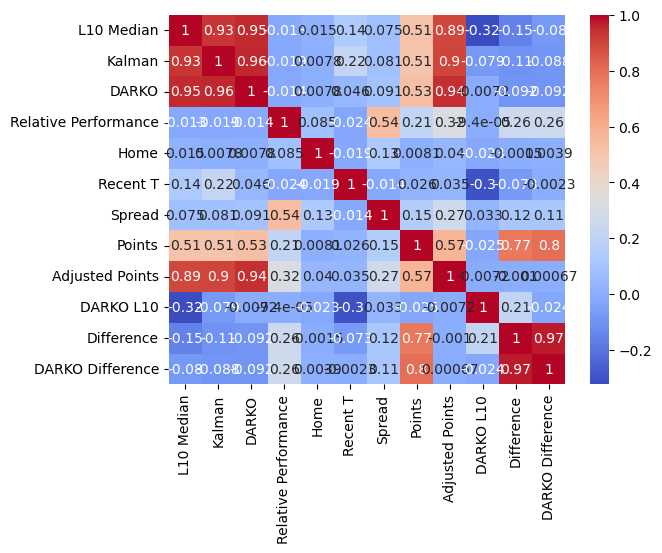

In [12]:
# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [13]:

# Perform independent samples t-test
# Statitical difference between home and away games avarage?

# Is there a significant difference between players that seem to be doing well recently
cutoff = 1.5
points_home_0 = df[df["Recent T"] <= cutoff]["Difference"].values
points_home_1 = df[df["Recent T"] > cutoff]["Difference"].values
print(len(points_home_0), len(points_home_1))
t_stat, p_value = ttest_ind(np.array(points_home_0), np.array(points_home_1))
print(t_stat)
print(p_value)

# Home and Away?

# Kolmogorov-Smirnov Test
# slightly right skewed
data = np.array(df['Relative Performance'])
kstest_stat, kstest_p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
print(f'Kolmogorov-Smirnov Test: Statistic={kstest_stat}, p-value={kstest_p}')
if kstest_p > 0.05:
    print("Sample looks Gaussian (fail to reject H0)")
else:
    print("Sample does not look Gaussian (reject H0)")

# Residuals are NOT normally distributed -- suggests that a Kalman filter purely applied cannot be the best option
# Relative Performance is relatively gaussian

# Slight overprediction for home games

1590 119
3.5342967166270616
0.00041975705765392226
Kolmogorov-Smirnov Test: Statistic=0.029650179519503495, p-value=0.09711970211934862
Sample looks Gaussian (fail to reject H0)


In [15]:
# Estimate median absolute error for all estimators
print(f"Kalman Error: {mean_absolute_error(df['Points'], df['Kalman'])}")
print(f"L10 Median Error: {mean_absolute_error(df['Points'], df['L10 Median'])}")
#print(f"Line Error: {mean_absolute_error(df['Points'], df['Line'])}")
print(f"DARKO Error: {mean_absolute_error(df['Points'], df['DARKO'])}") 
print(f"Adjusted Points Error: {mean_absolute_error(df['Points'], df['Adjusted Points'])}") 

#5.46 with median, 0.98
# with median, 0.99
#5.476 with mean, 0.98
#5.41 with mean, 0.98
#5.486 with mean, 0.99

# L10 Median is a LESS BIASED estimator of the median of points than the line itself 
# best unbiased estimator is L10 Median, but it doesn't get the side 

Kalman Error: 5.252074128680841
L10 Median Error: 5.269455822118198
DARKO Error: 5.1307163240884055
Adjusted Points Error: 4.982216712156734


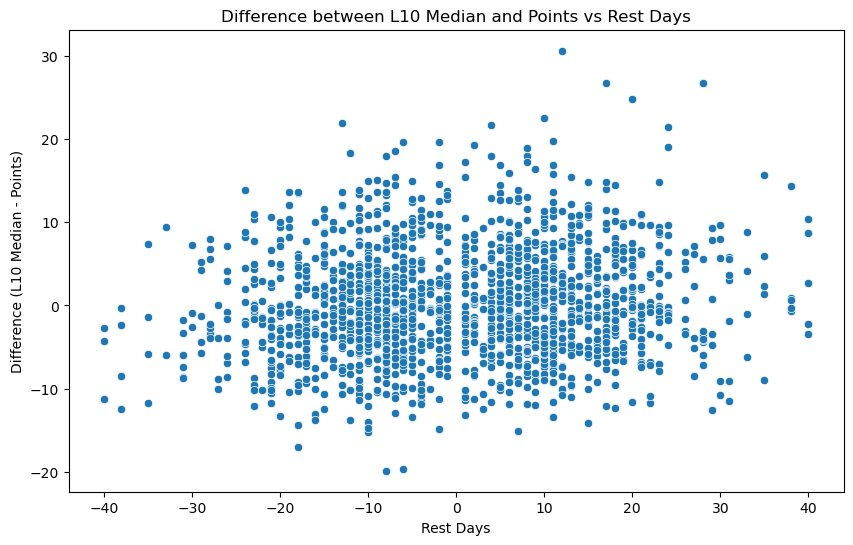

In [17]:

# Plot the difference against Rest Days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Spread', y='DARKO Difference')
plt.title('Difference between L10 Median and Points vs Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Difference (L10 Median - Points)')
plt.show()

# Relative performance vs team performance
# We should really be seeing a PARABOLIC trend -- player performance is maximized if it is a close game (i.e. points = -10 to 10) and minimized otherwise (points = 20 and above)

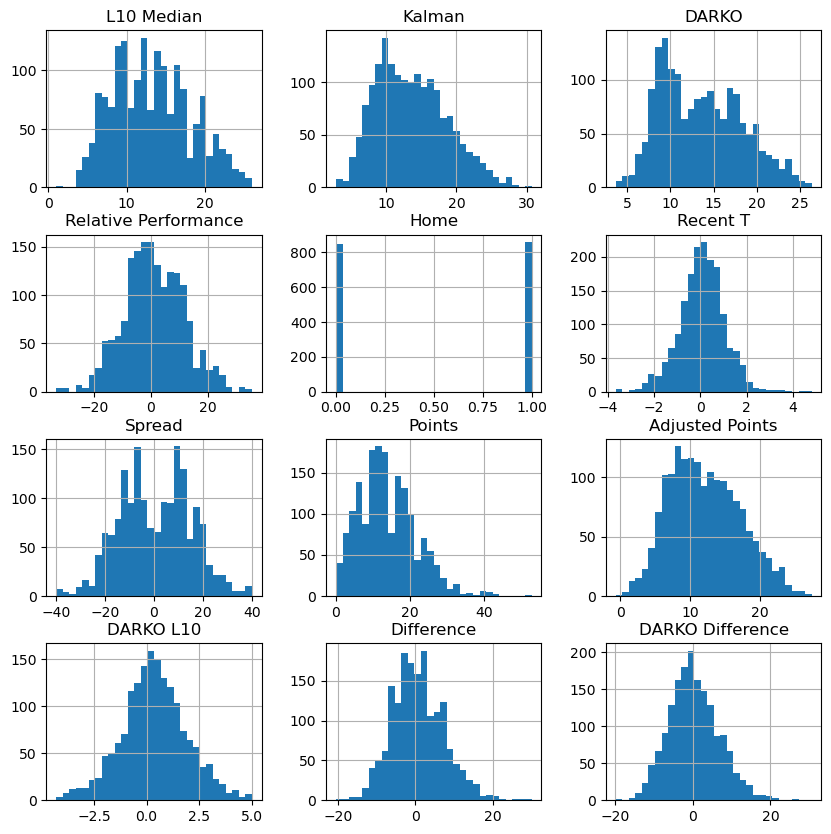

In [19]:
# Histograms
df.hist(bins=30, figsize=(10, 10))
plt.show()